In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:

df = pd.read_csv("gsearch_jobs.csv")
print("Dataset Shape:", df.shape)
df.head(5)  

Dataset Shape: (61953, 27)


,Unnamed: 0,index,title,company_name,location,via,description,extensions,job_id,thumbnail,...,commute_time,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_hourly,salary_yearly,salary_standardized,description_tokens
0,0,0,Data Analyst,Meta,Anywhere,via LinkedIn,In the intersection of compliance and analytic...,"['15 hours ago', '101K–143K a year', 'Work fro...",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,101K–143K,a year,122000.0,101000.0,143000.0,NaN,122000.0,122000.0,"['tableau', 'r', 'python', 'sql']"
1,1,1,Data Analyst,ATC,United States,via LinkedIn,Job Title: Entry Level Business Analyst / Prod...,"['12 hours ago', 'Full-time', 'Health insurance']",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
2,2,2,Aeronautical Data Analyst,"Garmin International, Inc.","Olathe, KS",via Indeed,Overview:\n\nWe are seeking a full-time...\nAe...,"['18 hours ago', 'Full-time']",eyJqb2JfdGl0bGUiOiJBZXJvbmF1dGljYWwgRGF0YSBBbm...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,['sql']
3,3,3,Data Analyst - Consumer Goods - Contract to Hire,Upwork,Anywhere,via Upwork,Enthusiastic Data Analyst for processing sales...,"['12 hours ago', '15–25 an hour', 'Work from h...",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgLSBDb25zdW...,NaN,...,NaN,15–25,an hour,20.0,15.0,25.0,20.0,NaN,41600.0,"['powerpoint', 'excel', 'power_bi']"
4,4,4,Data Analyst | Workforce Management,Krispy Kreme,United States,via LinkedIn,Overview of Position\n\nThis position will be ...,"['7 hours ago', '90K–110K a year', 'Contractor']",eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgfCBXb3JrZm...,https://encrypted-tbn0.gstatic.com/images?q=tb...,...,NaN,90K–110K,a year,100000.0,90000.0,110000.0,NaN,100000.0,100000.0,"['powerpoint', 'excel', 'outlook', 'word']"


In [3]:
data = df.copy()
data.drop_duplicates(inplace=True)


drop_cols = ["index", "thumbnail", "via", "extensions", "commute_time"]
data.drop(columns=drop_cols, inplace=True, errors='ignore')


text_cols = ["title", "company_name", "location", "description", "search_term", "search_location"]
for col in text_cols:
    data[col] = data[col].fillna("Unknown")


def parse_salary(sal_str):
    """Extract numeric salary from strings like '101K–143K a year'"""
    if pd.isna(sal_str):
        return (np.nan, np.nan)
    sal_str = str(sal_str).lower().replace(",", "")
    matches = re.findall(r'(\d+\.?\d*)\s*([km]?)', sal_str)
    nums = []
    for num, suffix in matches:
        num = float(num)
        if suffix == 'k':
            num *= 1000
        elif suffix == 'm':
            num *= 1_000_000
        nums.append(num)
    if len(nums) == 2:
        return (nums[0], nums[1])
    elif len(nums) == 1:
        return (nums[0], nums[0])
    else:
        return (np.nan, np.nan)

data["salary_min"], data["salary_max"] = zip(*data["salary"].apply(parse_salary))
data["final_salary"] = (data["salary_min"] + data["salary_max"]) / 2


data = data[~data["final_salary"].isna()]
data = data[data["final_salary"] > 0]

print("Dataset shape after removing null/zero salaries:", data.shape)


for col in ["posted_at", "date_time"]:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors="coerce")

if "posted_at" in data.columns:
    data["year"] = data["posted_at"].dt.year
    data["month"] = data["posted_at"].dt.month
    data["day"] = data["posted_at"].dt.day
    data["weekday"] = data["posted_at"].dt.day_name()

def clean_location(loc):
    if pd.isna(loc):
        return ("Unknown", "Unknown")
    parts = loc.split(",", 1)
    city = parts[0].strip()
    state = parts[1].strip() if len(parts) > 1 else "Unknown"

  
    city_map = {
        "anywhere": "Remote",
        "remote": "Remote",
        "usa": np.nan,
        "united states": np.nan,
        "united states of america": np.nan,
        "na": np.nan,
        "unknown": np.nan
    }
    city_clean = city_map.get(city.lower(), city)
    return (city_clean, state)

data["city"], data["state"] = zip(*data["location"].apply(clean_location))
data["city_clean"] = data["city"].str.title()
data = data[~data["city_clean"].isna()]   # drop bad cities


data["title_clean"] = data["title"].str.lower().str.strip()

def normalize_title(title):
    t = title.lower()

  
    if re.search(r"\b(senior|lead)\b", t):
        return "Senior Data Analyst"

    t = re.sub(r"\b(i{1,3}|iv|v)\b", "", t).strip()

    # Role categories
    if "business" in t:
        return "Business Data Analyst"
    elif "scientist" in t:
        return "Data Scientist"
    elif "engineer" in t:
        return "Data/Analytics Engineer"
    elif "analyst" in t:
        return "Data Analyst"
    else:
        return "Other"

data["title_category"] = data["title_clean"].apply(normalize_title)

if "description_tokens" in data.columns:
    data["description_tokens"] = data["description_tokens"].fillna("").str.lower()

print("\nCleaned dataset sample:")
print(data[["title", "title_category", "city_clean", "state", "final_salary"]].head())

Dataset shape after removing null/zero salaries: (10088, 23)

Cleaned dataset sample:
                                               title       title_category  \
0                                       Data Analyst         Data Analyst   
3   Data Analyst - Consumer Goods - Contract to Hire         Data Analyst   
10                               Senior Data Analyst  Senior Data Analyst   
21  Associate Research/Data Analyst-CES - Now Hiring         Data Analyst   
26         Data Analytics Mentor for Online Bootcamp                Other   

        city_clean    state  final_salary  
0           Remote  Unknown    122000.000  
3           Remote  Unknown        20.000  
10          Remote  Unknown        57.260  
21  Jefferson City       MO        23.265  
26          Remote  Unknown        65.000  


/var/folders/ml/6hkz87xd7t3d7st3zr6qzgzc0000gn/T/ipykernel_29067/1088215711.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors="coerce")


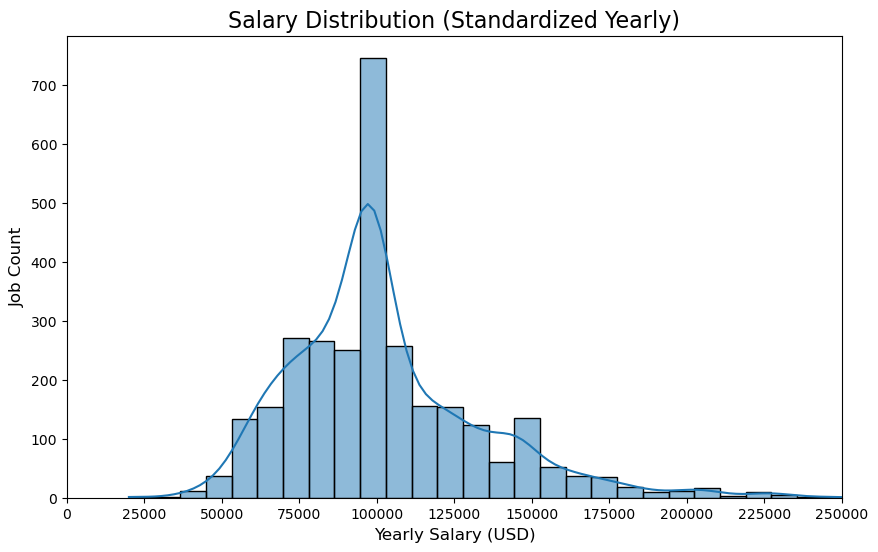

In [4]:
salary_data = data[(data["final_salary"] > 10000)]  # remove <= 10k salaries

plt.figure(figsize=(10,6))
sns.histplot(data=salary_data, x="final_salary", bins=50, kde=True)
plt.title("Salary Distribution (Standardized Yearly)", fontsize=16)
plt.xlabel("Yearly Salary (USD)", fontsize=12)
plt.ylabel("Job Count", fontsize=12)
plt.xlim(0, 250000)
plt.xticks(range(0, 250001, 25000))
plt.show()


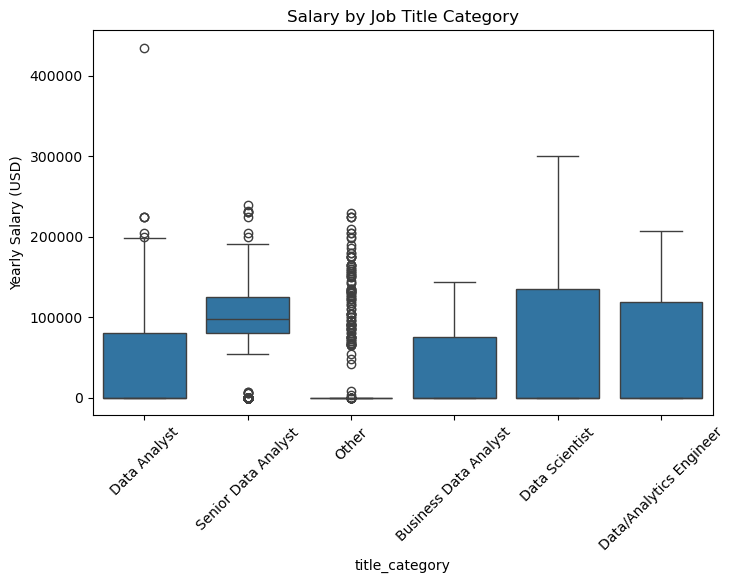

In [5]:
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x="title_category", y="final_salary")
plt.title("Salary by Job Title Category")
plt.xticks(rotation=45)
plt.ylabel("Yearly Salary (USD)")
plt.show()


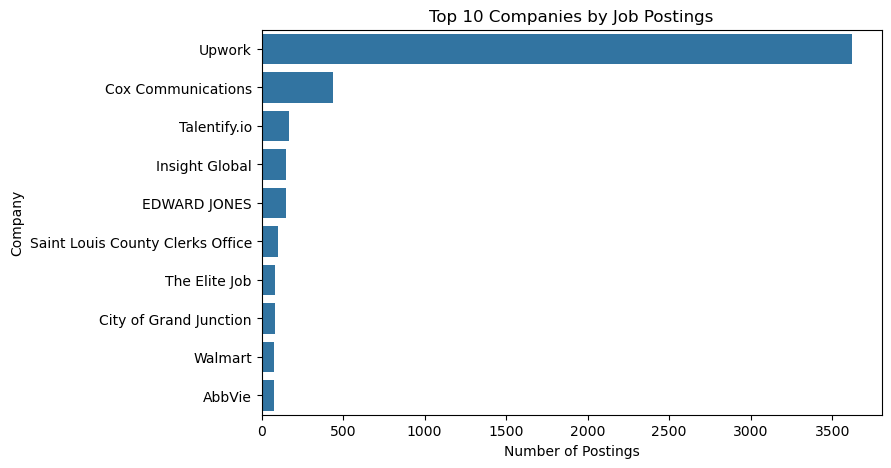

In [6]:
top_companies = data["company_name"].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_companies.values, y=top_companies.index)
plt.title("Top 10 Companies by Job Postings")
plt.xlabel("Number of Postings")
plt.ylabel("Company")
plt.show()

/var/folders/ml/6hkz87xd7t3d7st3zr6qzgzc0000gn/T/ipykernel_29067/2463146657.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data, x="work_from_home", palette="Set2")


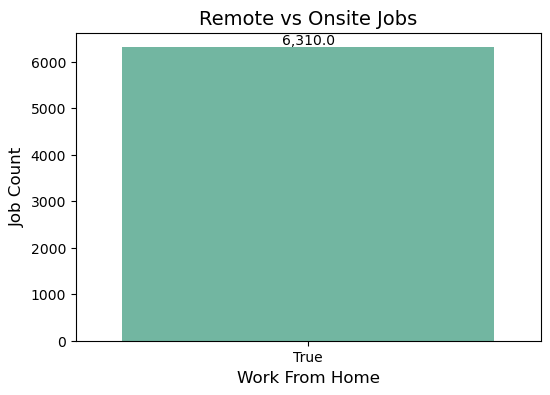

In [7]:
if "work_from_home" in data.columns:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=data, x="work_from_home", palette="Set2")

    
    for p in ax.patches:
        ax.annotate(f"{p.get_height():,}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

    plt.title("Remote vs Onsite Jobs", fontsize=14)
    plt.xlabel("Work From Home", fontsize=12)
    plt.ylabel("Job Count", fontsize=12)
    plt.show()


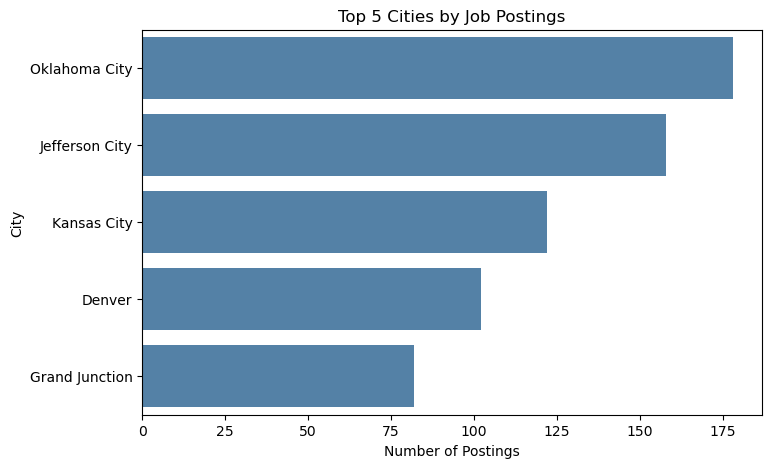

In [8]:



states = data["state"].dropna().unique().tolist()
states_lower = [s.lower() for s in states]


city_data = data[
    (~data["city"].str.lower().eq("remote")) &
    (~data["city"].str.lower().isin(states_lower))
]


top_cities = city_data["city"].value_counts().head(5)


plt.figure(figsize=(8,5))
sns.barplot(x=top_cities.values, y=top_cities.index, color="steelblue")
plt.title("Top 5 Cities by Job Postings")
plt.xlabel("Number of Postings")
plt.ylabel("City")
plt.show()




In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import re


def extract_seniority(title):
    if re.search(r"\b(Senior|Lead|Principal)\b", title, re.IGNORECASE):
        return "Senior"
    elif re.search(r"\b(Junior|Entry|Intern)\b", title, re.IGNORECASE):
        return "Junior"
    else:
        return "Mid"

data["seniority"] = data["title_category"].apply(extract_seniority)


X = data[["title_category", "state", "city_clean", "seniority"]].copy()
y = data["final_salary"].copy()


X = X[~y.isna()]
y = y.dropna()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), 
     ["title_category", "state", "city_clean", "seniority"])
])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300, 
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ))
])


model.fit(X_train, y_train)
preds = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, preds))

sample_jobs = pd.DataFrame({
    "title_category": ["Data Analyst", "Senior Data Scientist", "Business Intelligence Analyst"],
    "state": ["CA", "NY", "TX"],   
    "city_clean": ["San Francisco", "New York", "Dallas"],
    "seniority": ["Mid", "Senior", "Mid"]  
})

predicted_salaries = model.predict(sample_jobs)
print("\nSample Predictions:")
for job, sal in zip(sample_jobs["title_category"], predicted_salaries):
    print(f"{job}: Predicted Salary = ${sal:,.0f}")


MAE: 32373.278632932568

Sample Predictions:
Data Analyst: Predicted Salary = $89,294
Senior Data Scientist: Predicted Salary = $101,195
Business Intelligence Analyst: Predicted Salary = $67,925


In [10]:
!pip install catboost


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import pandas as pd
import re

def extract_seniority(title):
    if re.search(r"\b(Senior|Lead|Principal)\b", title, re.IGNORECASE):
        return "Senior"
    elif re.search(r"\b(Junior|Entry|Intern)\b", title, re.IGNORECASE):
        return "Junior"
    elif re.search(r"\b(I|II|III|IV|V)\b", title, re.IGNORECASE):
        return "Level"
    else:
        return "Mid"

data["seniority"] = data["title_category"].apply(extract_seniority)

X = data[["title_category", "state", "city_clean", "seniority"]].copy()
y = data["final_salary"].copy()
X = X[~y.isna()]
y = y.dropna()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_features = ["title_category", "state", "city_clean", "seniority"]

model = CatBoostRegressor(
    iterations=2000,
    depth=10,
    learning_rate=0.05,
    loss_function="MAE",
    random_seed=42,
    early_stopping_rounds=100,
    verbose=200
)

model.fit(
    X_train,
    y_train,
    cat_features=categorical_features,
    eval_set=(X_test, y_test)
)

preds = model.predict(X_test)
print("MAE on test set:", mean_absolute_error(y_test, preds))

sample_jobs = pd.DataFrame({
    "title_category": ["Data Analyst", "Senior Data Scientist", "Business Intelligence Analyst", "Lead Data Engineer II"],
    "state": ["CA", "NY", "TX", "WA"],
    "city_clean": ["San Francisco", "New York", "Dallas", "Seattle"],
})

sample_jobs["seniority"] = sample_jobs["title_category"].apply(extract_seniority)

predicted_salaries = model.predict(sample_jobs)
print("\nSample Predictions:")
for job, sal in zip(sample_jobs["title_category"], predicted_salaries):
    print(f"{job}: Predicted Salary = ${sal:,.0f}")




0:	learn: 34758.4155202	test: 35283.7333806	best: 35283.7333806 (0)	total: 59.9ms	remaining: 1m 59s
200:	learn: 23469.4972494	test: 24128.6937478	best: 24125.4305257 (183)	total: 457ms	remaining: 4.09s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 24111.63991
bestIteration = 214

Shrink model to first 215 iterations.
MAE on test set: 24111.639907581124

Sample Predictions:
Data Analyst: Predicted Salary = $116,342
Senior Data Scientist: Predicted Salary = $84,524
Business Intelligence Analyst: Predicted Salary = $52,037
Lead Data Engineer II: Predicted Salary = $84,524
